# Normal NN with MSE loss (from some old test)

    1. Train on OMM only

In [1]:
import time, sys, os
import numpy as np
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torchsummary import summary
import tqdm
from scipy.stats import norm
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt

os.environ["CUDA_VISIBLE_DEVICES"]="0"

# Basic Settings

In [2]:
# use GPUs if available
if torch.cuda.is_available():
    print("CUDA Available")
    device = torch.device('cuda')
    use_cuda=True
else:
    print('CUDA Not Available')
    device = torch.device('cpu')
    use_cuda=False
cudnn.benchmark = True      #May train faster but cost more memory


CUDA Available


In [3]:
STATS = 'WL_23_WPH_short_CMBWL'

GAUSSIAN_AUG_STRENTH = 0.1
BATCH_SIZE           = 16
LEARNING_RATE        = 0.0005
NUM_EPOCH            = 200
WEIGHT_DECAY_RATE    = 0.01
SCHEDULER_FACTOR     = 0.3
SCHEDULER_PATIENCE   = 10




In [4]:
DD = np.load('/global/cfs/cdirs/des/mgatti/CMB_lensing/DV/SBI_forecast/compression/compression_data_combined.npy',allow_pickle=True).item()
stat = DD['stat']
mask = DD['mask']
target = DD['data']

# wph get rid of stuff that's degenerate with wl2 and wl3
# this defines "WPH_short"
mask_l = np.array(16*[ True,  True,  True,  True, False, False,  True,  True,  True,
        True,  True,  True, False, False, False, False,  True,  True,
        True,  True, False, False, False, False,  True,  True, False,
       False, False, False, False, False, False, False, False, False])
mask_nbody_wph = np.hstack([np.array([False]*60),np.array([False]*120),mask_l])

# these keys are DVs that don't exist. 
# These indices are defined to select from their corresponding odict ('original dictionary') DVs that do exist
indict2 = dict()
indict2['WL_23_WPH_short'] = np.concatenate( ( list( range(320) ), np.array( range(320, 1076))[mask_nbody_wph]) )
indict2['WL_3_WPH_short'] = np.concatenate( ( list( range(160, 320) ), np.array( range(320, 1076))[mask_nbody_wph]) )
indict2['WL_23_WPH_short_CMBWL'] = np.concatenate( ( list( range(320) ), np.array( range(320, 1076))[mask_nbody_wph], list(range(1076, 1108) )) )
indict2['WPH'] = np.array( range(160, 916))[mask_nbody_wph]
indict2['CMBWL'] = range(160, 192)

odict = dict()
odict['WL_3_WPH_short'] = 'WL_23_WPH'
odict['WL_23_WPH_short'] = 'WL_23_WPH'
odict['WL_23_WPH_short_CMBWL'] = 'WL_23_WPH_WCMBL'
odict['WPH'] = 'WL_2_WPH'
odict['CMBWL'] = 'WL_2_WCMBL'

for key in odict.keys():
    print(key)
    stat[key] = stat[odict[key]].copy()
    stat[key]['dv'] = stat[key]['dv'][:,indict2[key]]
        

swapind = np.array([0,1,2,3,4,13,14,15,9,10,11,12,5,6,7,8,16])   # om s8 w a e .    ob ns h ...   dm dz

for key in stat.keys():
    stat[key]['params'] = stat[key]['params'][:,swapind]

# defining additional_mask that filters away some extreme values of w, A, eta
parms = stat['WL_2']['params']
extra =   (parms[:,3]<0.8)  & (parms[:,3]>0.2) &\
         (parms[:,4]>0.1) &   (parms[:,4]<0.9) 

additional_mask = (stat['WL_2']['params'][:,2]>0.1)&extra



WL_3_WPH_short
WL_23_WPH_short
WL_23_WPH_short_CMBWL
WPH
CMBWL


In [5]:
# these are the pars/DV that will be used to train the compression (or whatever pre-processing).
pars_train = np.array(stat[STATS]['params'][mask&additional_mask,:16])
dv = np.array(stat[STATS]['dv'][mask&additional_mask,:])

    # these are the pars/DV that will be used for the LFI step later on 
    # (so you apply whatever compression/preprocessing to these and give to NDE)
pars_LFI = np.array(stat[STATS]['params'][(~mask)&additional_mask,:16])
dv_LFI = np.array(stat[STATS]['dv'][(~mask)&additional_mask,:])

# Start Normalization

In [6]:
# no normalization

# train only on OMM
pars_train = pars_train[:, 0:1]
pars_LFI = pars_LFI[:, 0:1]

In [7]:
num_samples = len(pars_train)
# split the sample for training ----------
train_split, val_split = int(0.9*num_samples), int(0.1*num_samples)

train_x, val_x = np.split(dv, [train_split])
train_y, val_y = np.split(pars_train, [train_split])

train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(train_x[:]), torch.from_numpy(train_y[:]))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(torch.from_numpy(val_x[:]), torch.from_numpy(val_y))
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE)

test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(dv_LFI[:]), torch.from_numpy(pars_LFI))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

print('checking data set sizes',train_dataset.tensors[0].shape, val_dataset.tensors[0].shape, test_dataset.tensors[0].shape)

checking data set sizes torch.Size([8211, 608]) torch.Size([913, 608]) torch.Size([8187, 608])


# Start Training

In [8]:
def train_model(model, 
                train_loader, 
                val_loader,
                dataset_size, 
                val_size, 
                optimizer, 
                num_epochs):
    model.to(device)
    criterion = nn.MSELoss()
    for epoch in range(num_epochs):
        if epoch % 10 == 0:
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print('-' * 10)
        model.train()

        running_loss = 0.0
        # Iterate over data.
        for bi, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device, dtype=torch.float)
            labels = labels.to(device, dtype=torch.float)

            optimizer.zero_grad()

            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / dataset_size
        train_losses_tracker.append(epoch_loss)
        if epoch % 10 == 0:
            print('Loss: {:.4f}'.format(epoch_loss))
        
        if epoch % 1 == 0:
            model.eval()
            running_loss = 0.0
            # Iterate over data.
            for bi, (inputs, labels) in enumerate(val_loader):
                inputs = inputs.to(device, dtype=torch.float)
                labels = labels.to(device, dtype=torch.float)

                with torch.no_grad():
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)
            epoch_val_loss = running_loss / val_size
            valid_losses_tracker.append(epoch_val_loss)
            scheduler.step(epoch_val_loss)
        if epoch % 10 == 0:  
            print('Val Loss: {:.4f}'.format(epoch_val_loss))
            
    return model

In [9]:
def plot_test_error(model, test_loader,output=False, out_name='test', Y_min=0, Y_max=1, color='steelblue'):

    g=[0]

    test_loss1, test_loss2 = torch.zeros(len(g)).to(device), torch.zeros(len(g)).to(device)
    test_loss, points = 0.0, 0

    ## Model performance metrics on test set
    num_maps=test_loader.dataset.tensors[0].shape[0]

    # define the arrays containing the value of the parameters
    params_true = np.zeros((num_maps,len(g)), dtype=np.float32)
    params_NN   = np.zeros((num_maps,len(g)), dtype=np.float32)
    errors_NN   = np.zeros((num_maps,len(g)), dtype=np.float32)

    model.eval()
    for x, y in test_loader:
        with torch.no_grad():
            bs    = x.shape[0]         #batch size
            if x.dtype == torch.float64:
                x = x.float()
            x     = x.to(device)       #send data to device
            y     = y.to(device)  #send data to device
            p     = model(x)           #prediction for mean and variance
            y_NN  = p           #prediction for mean

            # save results to their corresponding arrays
            params_true[points:points+x.shape[0]] = y.cpu().numpy() 
            params_NN[points:points+x.shape[0]]   = y_NN.cpu().numpy()

            points    += x.shape[0]
            
    # normalization if needed
    params_true = params_true * (Y_max - Y_min) + Y_min
    params_NN   = params_NN   * (Y_max - Y_min) + Y_min
    
    test_error = 100*np.mean(np.sqrt((params_true - params_NN)**2)/params_true,axis=0)
    
    RMSE = np.sqrt(np.mean((params_true - params_NN)**2,axis=0))
    RMSE_P = RMSE*100
    params_true_mean = np.mean(params_true)
    tmp = np.mean((params_true - params_true_mean)**2, axis=0)
    R2 = 1 - (RMSE)**2 / tmp
    # print('Error Omega_m = %.3f'%test_error[0])
    print(r' RMSE = %.3f'%RMSE[0])
    print(r' $R^2$ = %.3f'%R2[0])
    print('Error S_8 = %.3f'%test_error[0])


    f, axarr = plt.subplots(1, 1, figsize=(5,5))
    axarr.plot(np.linspace(min(params_true[:,0]),max(params_true[:,0]),100),np.linspace(min(params_true[:,0]),max(params_true[:,0]),100),color="black")

    axarr.plot(params_true[:,0],params_NN[:,0],marker="o",ls="none",markersize=2, color=color)
    axarr.set_xlabel(r"True $S_8$")
    axarr.set_ylabel(r"Predicted $S_8$")
    # axarr.text(0.1,0.9,"%.3f %% error" % test_error[0],fontsize=12,transform=axarr.transAxes)
    
    axarr.text(0.08,0.9,r"RMSE = %.3f %% " % RMSE_P[0],fontsize=12,transform=axarr.transAxes)
    axarr.text(0.08,0.82,r"$R^2$ = %.3f" % R2[0],fontsize=12,transform=axarr.transAxes)
    
    
    # axarr[1].plot(np.linspace(min(params_true[:,1]),max(params_true[:,1]),100),np.linspace(min(params_true[:,1]),max(params_true[:,1]),100),color="black")
    # axarr[1].plot(params_true[:,1],params_NN[:,1],marker="o",ls="none",markersize=2)
    # axarr[1].set_xlabel(r"True $S_8$")
    # axarr[1].set_ylabel(r"Predicted $S_8$")
    # axarr[1].text(0.1,0.9,"%.3f %% error" % test_error[1],fontsize=12,transform=axarr[1].transAxes)

    if output:
        f.savefig('./output/'+out_name+'.pdf', dpi=300, format='pdf')

        # Also save for LFI later
        info = dict()
        info['params'] = params_true
        info['compressed_DV'] = params_NN
        np.save('./output/'+out_name+'_compressed_dv',info)

In [10]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(608, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )
    
    def forward(self, x):
        return self.layers(x)

model = MLP()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.3, patience=10)

train_losses_tracker   = []
valid_losses_tracker   = []

model = train_model(model, train_loader, val_loader, len(train_y), len(val_y), optimizer, NUM_EPOCH)


Epoch 0/199
----------
Loss: 0.0111
Val Loss: 181.6840
Epoch 10/199
----------
Loss: 0.0020
Val Loss: 412.9165
Epoch 20/199
----------
Loss: 0.0017
Val Loss: 11.3924
Epoch 30/199
----------
Loss: 0.0013
Val Loss: 0.0428
Epoch 40/199
----------
Loss: 0.0013
Val Loss: 11.5083
Epoch 50/199
----------
Loss: 0.0013
Val Loss: 8.0096
Epoch 60/199
----------
Loss: 0.0012
Val Loss: 1.0512
Epoch 70/199
----------
Loss: 0.0012
Val Loss: 0.6601
Epoch 80/199
----------
Loss: 0.0012
Val Loss: 0.0704
Epoch 90/199
----------
Loss: 0.0012
Val Loss: 0.0059
Epoch 100/199
----------
Loss: 0.0012
Val Loss: 0.1013
Epoch 110/199
----------
Loss: 0.0012
Val Loss: 0.0019
Epoch 120/199
----------
Loss: 0.0012
Val Loss: 0.0020
Epoch 130/199
----------
Loss: 0.0012
Val Loss: 0.0125
Epoch 140/199
----------
Loss: 0.0012
Val Loss: 0.0016
Epoch 150/199
----------
Loss: 0.0012
Val Loss: 0.0017
Epoch 160/199
----------
Loss: 0.0012
Val Loss: 0.0011
Epoch 170/199
----------
Loss: 0.0012
Val Loss: 0.0027
Epoch 180/199
-

 RMSE = 0.035
 $R^2$ = 0.774
Error S_8 = 8.418


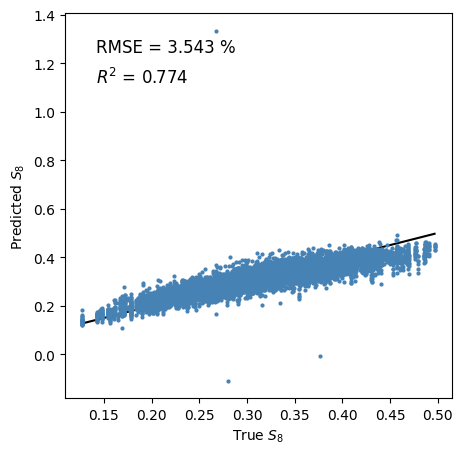

In [11]:
%matplotlib inline

plot_test_error(model, test_loader, out_name = 'test_3_2',Y_min=0, Y_max=1)
